## Perceptron and Data augmentation 
In this showcase we use the Perceptron classifier to classify two characters. In the next cells of this notebook, images having the characters are loaded and a couple of variations for them are created. Finally, we classify everything using sklearn's Perceptron implementation.

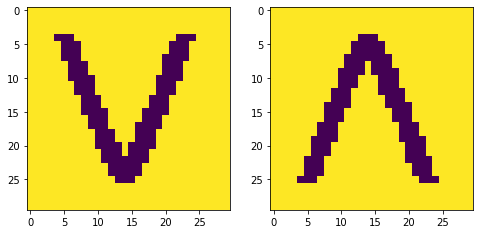

In [2]:
from skimage.io import imread
from matplotlib import pyplot as plt

# Read images having the two characters to be classified.
V = imread("../data/raw/V.png", as_gray=True)
V_inv = imread("../data/raw/inv_V.png", as_gray=True)

# Exhibits the two images loaded.
rows = 1
columns = 2
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(rows, columns, 1)
plt.grid(False)
plt.imshow(V)
fig.add_subplot(rows, columns, 2)
plt.grid(False)
plt.imshow(V_inv)
plt.show()


---

Given the loaded images, we have a data augmentation step to create 16 variations of them. The `gen_data` function is responsible for generating any desired number of random variations all based in a single input image. Variations are created using pepper noise and image rotations.

In [3]:
import random
from skimage.util import random_noise
from skimage import transform

def gen_data(base_image, quantity, label, data, target):
    """Function to generate image variations based on input parameters
    for image to use, quantity to generate, label to set for generated
    images, list of generated images and list of labels.

    Args:
        base_image (ndarray): The image to base every generated image.
        quantity (int): Number of images to generate.
        label (int): Label to use for every image generated.
        data (List[ndarray]): List to append generated images.
        target (List[int]): List to append generated images' labels.
    """
    for i in range(0, quantity):
        pepper_noise_seed = random.randint(10, 20)
        rotation_degrees = random.uniform(-25, 25)
        
        # First apply pepper effect, then rotate image and append it to
        # list of generated images.
        noise_fig = random_noise(base_image, mode='pepper',seed=pepper_noise_seed, clip=True)
        rotate_fig = transform.rotate(noise_fig, rotation_degrees, resize=False,center=None, order=1, mode='constant', cval=1, clip=True, preserve_range=True)
        data.append(rotate_fig)
        target.append(label)
    
def plot_images(array, rows, columns):
    """Plot images in a grid with the specified number of rows and
    columns.

    Args:
        array (List[ndarray]): List of images to plot.
        rows (int): Number of rows in the grid.
        columns (int): Number of columns in the grid.
    """
    fig = plt.figure(figsize=(8, 8))

    for i, j in enumerate(array):
        fig.add_subplot(rows, columns, i + 1)
        plt.grid(False)
        plt.imshow(j)
    plt.show()


---


Call generator and plotting funtions defined above to show example of generated images.

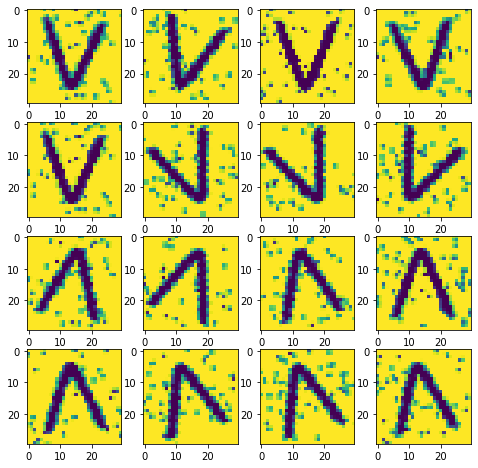

In [4]:
import numpy as np

X = []
y = []

# Call function to generate 16 images based on the 2 original images. 0 
# and 1 are the labels for variations based on the first and the second
# original image, respectively.
gen_data(V, 8, 0, X, y)
gen_data(V_inv, 8, 1, X, y)
X = np.asarray(X)
y = np.asarray(y)

# Show generated images in a 4x4 grid.
plot_images(X, 4, 4)


---

The augmented dataset with 16 images will be separated in a training set and a testing set having 12 and 4 images, respectively, using sklearn's function `train_test_split`. After that, a Perceptron classifier is trained and evaluated considering accuracy.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

# Reshape images so that we can use them as input to our Perceptron.
X_reshaped = np.reshape(X, (len(X), 900))

# Split training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.25, random_state=42)

# Instantiate and train Perceptron model.
classifier = Perceptron(tol=1e-3, random_state=0)
classifier.fit(X_train, y_train) 

# Find accuracy for both training and testing sets.
y_pred_test = classifier.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
y_pred_train = classifier.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

print('Testing set accuracy: %.2f' % acc_test)
print('Training set accuracy: %.2f' % acc_train)

Testing set accuracy: 1.00
Training set accuracy: 1.00


After reshaping the augmented image dataset and training a Perceptron on it, we can see that it achieves maximum accuracy. This is expected since our dataset has only two classes and both of them have singular features. Therefore, the problem can be seen as linearly separable and Perceptrons are known to be efficient in this particular task.


---

Perceptron's original activation function, the step function, can lead us to think that the model classifies the samples with the same confidence. However, this is not true. For sklearn's Perceptron, we can measure the model confidence for a given sample by calculating the relative distance from this sample to the separating hyperplane. Function `decision_function()` returns this measure to us:

In [18]:
# Load sample images.
x_q = [imread("../data/raw/query0.png", as_gray=True), imread("../data/raw/query1.png", as_gray=True), 
       imread("../data/raw/query2.png", as_gray=True), imread("../data/raw/query4.png", as_gray=True)]

# Reshape images to pass them to the model.
x_q =  np.reshape(x_q, (len(x_q), 900))

# Show the values that the decision function uses to classify samples.
print(classifier.decision_function(x_q))

[-11.66111818  16.86722563  37.89678909 -10.39213298]


Sklearn's Perceptron `decision_function` returns a confidence score, the signed distance between the input sample and the separating hyperplane. In binary cases, a positive value returned by the function means that the input sample would be classified for one class and, if the returned value is negative, for the other class.

Observing the quality of the symbols in the four example images, the first (query0) and fourth (query4) images actually have symbols with very low quality and quite different from the symbols present in both training and testing sets. This corroborates the low confidence score returned for these samples (closer to 0). The symbol present in the second figure (query1) has a higher quality, resulting in a good confidence score.

For the third image (query2) we have a high quality symbol that has similar appearance to the ones in the training set. It can be easily visualized as an inverted V and classified with the highest confidence by the Perceptron.

It is possible to conclude that the quality of the symbol present in the image directly affects the confidence of the classification, i.e., the distance to the separating hyperplane. Lower graphic quality, or less similarity between the sample and the training/testing set symbols, results in a lower prediction confidence, or smaller distance between the sample and the separating hyperplane.